In [5]:
import numpy as np
np.random.seed(0)

In [6]:
class DenseLayer:
    def __init__(self, n_units, 
        input_size, function_type, lr):
        
        self.n_units = n_units
        self.input_size = input_size
                
        # tanh activation function and its derivative
        if function_type == 'tanh':
            self.fn = lambda x: np.tanh(x)
            self.df = lambda x: 1-x**2
            
        # logistic activation function and its derivative
        elif function_type == 'logistic':
            self.fn = lambda x: 1 / (1 + np.exp(-x))
            self.df = lambda x: x * (1 - x)
        
        # Identity activation function and its derivative
        elif function_type == 'identity':
            self.fn = lambda x: x
            self.df = lambda x: np.ones(np.shape(x))
        
        #learning rate
        self.lr = lr
   
    def __call__(self, X, bias = True):
        
        # adding a vector of 1s for the bias-weight
        if bias:
            X_extended = np.hstack([
                np.ones((X.shape[0], 1)),
                X
            ])
        else:
            X_extended = X
        # applying transfer function
        return self.fn(X_extended)

In [7]:
class MultiLayerPerceptron:
    def __init__(self, output_size, input_size):
        
        # initializing layers
        self.layer_n = DenseLayer(n_units = 6, input_size = input_size, function_type = 'identity', lr = 0.01)
        self.layer_h = DenseLayer(n_units = 6, input_size = 6, function_type = 'logistic', lr = 0.02)
        self.layer_m = DenseLayer(n_units = output_size, input_size = 6, function_type = 'tanh', lr = 0.03)
        
        #initialize weights
        self.Wnh = np.random.uniform(-2, 2, (input_size + 1, 6))
        self.Whm = np.random.uniform(-2, 2, (6 + 1, output_size))
        
    def forward(self, X):
        # forward propagation
        return self.layer_n(X), self.layer_h(self.layer_n(X)@self.Wnh), self.layer_m(self.layer_h(self.layer_n(X)@self.Wnh)@self.Whm, bias = False)

    def backward(self, X, out_n, out_h, y_pred, y_true):
        error = y_true - y_pred
        
        #backpropagation from output layer to hidden layer
        derivative_m = np.array(list(map(self.layer_m.df,y_pred)))
        delta_m = error * derivative_m
        dW_hm = self.layer_m.lr * out_h.T @ delta_m
        self.Whm += dW_hm
        
        #backpropagation from hidden layer to input layer
        derivative_h = np.array(list(map(self.layer_h.df,out_h)))[:,1:]
        delta_h = delta_m@self.Whm[1:,:].T*derivative_h
        dW_nh = self.layer_h.lr * out_n.T @ delta_h 
        self.Wnh += dW_nh

    def mean_square_error(self, y_pred, y):
        return np.sqrt(((y_pred - y)**2).mean(axis=None))

In [8]:
import re
import requests

def parse_text_file(text):
    data = text.split('\n')
    
    # reading P, N, M using re
    P, N, M = map(int, re.findall(r'\d+', data[1]))
    
    X = np.zeros((P,N))
    y = np.zeros((P,M))
    for i, line in enumerate(data[2: 2 + P]):
        nums = list(map(float, line.split()))
        X[i] = nums[:N]
        y[i] = nums[N:]
    return P, N, M, X, y

text_file = requests.get(
  'https://raw.githubusercontent.com/AgentSamBond/Maching_learning_study/'
  'main/4204_Technical_Neural_Networks/'
  '1_Single_layer_perceptron/'
  'PA-A_training_data_06.txt'
).text
print(text_file)

P, N, M, X, y = parse_text_file(
    text_file
    )
print(f'P = {P}, N = {N}, M = {M}')
print('X =', X)
print('y =', y)



# WS22/23_TNN_Assignment_PA-A_data_File_No_1_PA-A_training_data_05.txt
# P=8    N=6    M=2   
0.0 0.0 0.0 0.0 1.0 0.0     0.1 0.9
0.0 1.0 1.0 0.0 0.0 0.0     0.9 0.1
0.0 0.0 1.0 0.0 0.0 0.0     0.1 0.1
0.0 1.0 0.0 0.0 1.0 0.0     0.9 0.9
0.0 1.0 0.0 0.0 0.0 0.0     0.9 0.1
0.0 0.0 1.0 0.0 1.0 0.0     0.1 0.9
1.0 1.0 0.0 0.0 0.0 0.0     0.9 0.1
1.0 0.0 1.0 0.0 1.0 0.0     0.1 0.9


P = 8, N = 6, M = 2
X = [[0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0.]]
y = [[0.1 0.9]
 [0.9 0.1]
 [0.1 0.1]
 [0.9 0.9]
 [0.9 0.1]
 [0.1 0.9]
 [0.9 0.1]
 [0.1 0.9]]


predictions: [[0.10014021 0.90438391]
 [0.89595684 0.1006157 ]
 [0.0990409  0.09711413]
 [0.88986946 0.88209834]
 [0.92591115 0.10366591]
 [0.100999   0.90969282]
 [0.89312484 0.09831244]
 [0.10061069 0.9099634 ]]


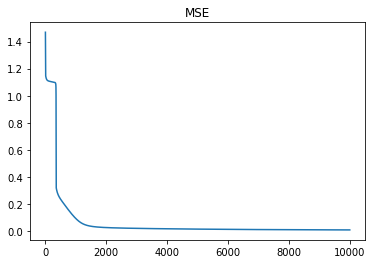

In [9]:
import matplotlib.pyplot as plt

model = MultiLayerPerceptron(output_size = M, input_size=N)

f = open("learning curve.txt", "w")
cycles_mse = []
for i in range(10000):
    out_n, out_h, y_pred = model.forward(X)
    model.backward(X, out_n, out_h, y_pred, y)
    cycles_mse.append([
        i,
        model.mean_square_error(y_pred, y)
    ])
    f.write(str(model.mean_square_error(y_pred, y)))
    f.write('\n')
f.close()
print('predictions:', y_pred)

x, y = zip(*cycles_mse)
plt.plot(x, y)
plt.title('MSE')
plt.show()


In [10]:
#validation
text_file = requests.get(
  'https://raw.githubusercontent.com/AgentSamBond/Maching_learning_study/main/'
  '4204_Technical_Neural_Networks/1_Single_layer_perceptron/'
  'PA-A_training_data_06.txt'
).text
print(text_file)

P, N, M, X, y = parse_text_file(
    text_file
    )
print(f'P = {P}, N = {N}, M = {M}')
print('X =', X)
print('y =', y)

out_n, out_h, y_pred = model.forward(X)
print('predictions:', y_pred)

# WS22/23_TNN_Assignment_PA-A_data_File_No_1_PA-A_training_data_05.txt
# P=8    N=6    M=2   
0.0 0.0 0.0 0.0 1.0 0.0     0.1 0.9
0.0 1.0 1.0 0.0 0.0 0.0     0.9 0.1
0.0 0.0 1.0 0.0 0.0 0.0     0.1 0.1
0.0 1.0 0.0 0.0 1.0 0.0     0.9 0.9
0.0 1.0 0.0 0.0 0.0 0.0     0.9 0.1
0.0 0.0 1.0 0.0 1.0 0.0     0.1 0.9
1.0 1.0 0.0 0.0 0.0 0.0     0.9 0.1
1.0 0.0 1.0 0.0 1.0 0.0     0.1 0.9


P = 8, N = 6, M = 2
X = [[0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0.]]
y = [[0.1 0.9]
 [0.9 0.1]
 [0.1 0.1]
 [0.9 0.9]
 [0.9 0.1]
 [0.1 0.9]
 [0.9 0.1]
 [0.1 0.9]]
predictions: [[0.10014025 0.90438277]
 [0.89595736 0.10061555]
 [0.09904069 0.09711454]
 [0.88986868 0.88210047]
 [0.92591035 0.10366546]
 [0.10099954 0.90969139]
 [0.89312567 0.09831268]
 [0.10061029 0.90996223]]
